# Kidney Exchange QAOA Example
Used samples from Classiq github on QAOA and internet for pyomo models  
Modified as needed for specfic problem and limitations based on account. 

<u>What is the Problem?</u>  
Currently there are more than 100,000 patients on the waitling list in the United States for a kidney transplant from a deceased donor. This is addressed by the a program called the Kidney Exchange Program.  This program won the Nobel Prize in Economics for Alvin E. Roth and Lloyd S. Shapley's contributions to the <i>theory of stable matchings and the design of markets on 2012.</i>
In summary, in a donor pair there is a recipient who needs a kidney transplant and a donor who is willing to give their kidney to the recipient. About $\frac{1}{3}$ of those pairs are not compatible for a direct exchange. This is tackled by considering two incompatible pairs together: donor 1 may be compatible with recpient 2 and donor 2 may be compatible with recpient 1. In this example a two-way swap becomes feasible. This is the core of the kideny exchange program.  

This is consdered an NP-Hard combinatorial optimization problem that becomes exponetially more difficult as the size of the pool increases. The longest chain in history involved 35 tranplants in the United States in 2015.

In [10]:
from pyomo.environ import *
from itertools import product

import matplotlib.pyplot as plt
import networkx as nx  # noqa
import numpy as np
import pandas as pd
import io
import sys
import time
from contextlib import redirect_stdout
from typing import List, Tuple, cast  # noqa

import pyomo.environ as pyo
from IPython.display import Markdown, display

## Create the pyomo model for a simple kidney exhange problem 
<u>2 donors and 2 recipients were used, since with 3 the classiq simualtor would error with more than 25 qubits requested</u>

In this very simple example, patients and donors represent sets of patients that receive a kidney from a donor. Compatibility is a dictionary mapping of patient-donor paris to their compatibilty scores. In this model patients and donors are paired up based on compatibility, and the aim to maximize the number of successful kidney exchanges. Binary decision variables are defined for each patient-donor pair x[p,d]. The objective is to maximize the total number of successful matches. $ Maximize \sum_{p,d\in A}^{}x_{dp}$ where d=donors, p=patients. The constraints ensure that each match is compatible based on the compatibility scores $\le 1$. Therefore, there will be a constraint for each coombination. We are creating a PYOMO model that gets fed into Classiq, as illustrated in Classiq documentation. We also solve initially with a classical solver to get inital results.

In [11]:
from pyomo.environ import *

# Sample data: patient-donor pairs and compatibility scores
patients=['P1','P2']
donors=['D1','D2']
N=len(patients)
M=len(donors)
#patients = ['P1', 'P2', 'P3']
#donors = ['D1', 'D2', 'D3']
compatibility = {
    ('P1', 'D1'): 0.8,
    ('P1', 'D2'): 0.5,
    #('P1', 'D3'): 0.3,
    ('P2', 'D1'): 0.7,
    ('P2', 'D2'): 0.9,
#    ('P2', 'D3'): 0.2,
#    ('P3', 'D1'): 0.4,
#    ('P3', 'D2'): 0.6,
#    ('P3', 'D3'): 0.1,
}

# Create Pyomo model
model = ConcreteModel()

# Define variables
model.x = Var(patients, donors, within=Binary)

# Define objective function
model.obj = Objective(expr=sum(model.x[p, d] for p in patients for d in donors),
                      sense=maximize)

# Define constraints
def compatibility_constraint(model, p, d):
    return model.x[p, d] * compatibility[p, d] <= 1

model.compatibility_constraint = Constraint(patients, donors, rule=compatibility_constraint)

# Solve the model
solver = SolverFactory('glpk')
solver.solve(model)

# Print the results
print("Optimal pairs:")
for p in patients:
    for d in donors:
        if model.x[p, d].value == 1:
            print(f"Patient {p} is matched with Donor {d} (Compatibility: {compatibility[p, d]})")


model.pprint()
#print(x)

Optimal pairs:
Patient P1 is matched with Donor D1 (Compatibility: 0.8)
Patient P1 is matched with Donor D2 (Compatibility: 0.5)
Patient P2 is matched with Donor D1 (Compatibility: 0.7)
Patient P2 is matched with Donor D2 (Compatibility: 0.9)
6 Set Declarations
    compatibility_constraint_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain                                                            : Size : Members
        None :     2 : compatibility_constraint_index_0*compatibility_constraint_index_1 :    4 : {('P1', 'D1'), ('P1', 'D2'), ('P2', 'D1'), ('P2', 'D2')}
    compatibility_constraint_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'P1', 'P2'}
    compatibility_constraint_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'D1', 'D2'}
    x_index : Size=1, Index=None, Ordered=True
        

## Start Generatng the QAOA Process
  
### Create the inital parameters for the quantum circuit. These can me modified as needed.
1. Defining the number of layers (num_layers) of the QAOA Ansatz.  
2. Define the penalty_energy for invalid solutions, which influences the convergence rate. Smaller positive values are preferred, but shoudl be tweaked.  


In [12]:
from classiq import (
    Preferences,
    construct_combinatorial_optimization_model,
    set_preferences,
)
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=5, penalty_energy=3.0)

### Create the classical optimizer part of the QAOA. These parameters can be modified.
1. opt_type is the classical optimizer type. Choices include, COBYLA, SPSA, ADAM, L_BFGS_B, and NELDER_MEAD
2. The max_iterations is the maximum number of optimzer iterations and is set to 100.  
3. The alpha_cvar is a parameter that describes the quantile considered in the CVAR expectation value. See https://arxiv.org/abs/1907.04769 for more information.

In [13]:
optimizer_config = OptimizerConfig(
    max_iteration=100,
    alpha_cvar=1,
)

### Combine everthing together to form the entire QAOA model as a QMOD.
1. PYOMO Model  
2. QAOA quantum circuit  
3. Clasical optimizer  

In [14]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

# defining cosntraint such as computer and parameters for a quicker and more optimized circuit.
preferences = Preferences(transpilation_option="none", timeout_seconds=3000)

qmod = set_preferences(qmod, preferences)

1. Wite out the QMOD and preferences to a JSON file  
2. Synthesize the model in Classiq interface  
 

In [15]:
from classiq import write_qmod
write_qmod(qmod, "Kidney Exchange")

1. Sythesize the quantum model
2. Show the quantm model in the Classiq platform

In [16]:
from classiq import show, synthesize
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/e12eff4f-9b8e-4fa3-af26-ef8c78462ca3?version=0.42.0


Execute the quantum model and store the result.

In [17]:
from classiq import execute
res = execute(qprog).result()

View the convergence graph  
<i>Important to remember that this is a maximization problem when looking at the graph</i>

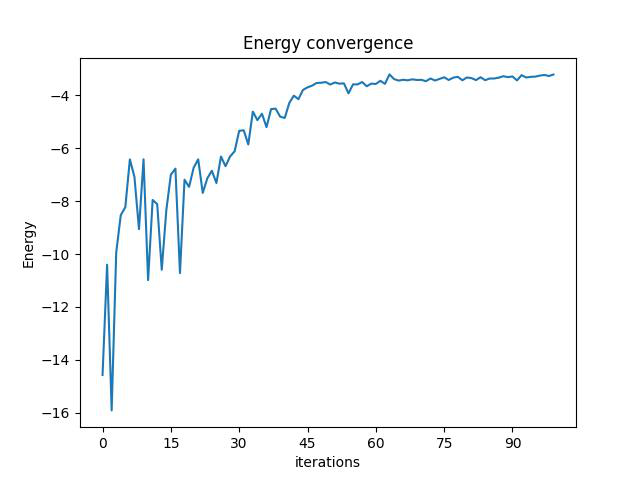

In [18]:
from classiq.execution import VQESolverResult

vqe_result=res[0].value
vqe_result.convergence_graph

## Retrieve the Best Solutions
- Print them out
- Graph them in hisotgram
- Show Donor - Recipients in Network Graph

In [19]:
import pandas as pd
from classiq.applications.combinatorial_optimization import (get_optimization_solution_from_pyo, )

solution = get_optimization_solution_from_pyo(model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy)

optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(10)

,probability,cost,solution,count
468,0.000488,-21.442224,"[1, 0, 0, 1]",1
623,0.000488,-20.013653,"[1, 1, 0, 0]",1
604,0.000488,-19.966034,"[0, 0, 1, 1]",1
615,0.000488,-19.799367,"[0, 1, 1, 1]",1
528,0.000488,-18.870796,"[1, 0, 0, 1]",1
337,0.000977,-18.442224,"[1, 0, 0, 1]",2
883,0.000488,-18.013653,"[0, 1, 0, 1]",1
699,0.000488,-17.870796,"[1, 1, 0, 1]",1
430,0.000488,-17.370796,"[0, 1, 0, 1]",1
243,0.000977,-17.299367,"[1, 1, 1, 1]",2


### Histogram of Cost and Weighted by Probability

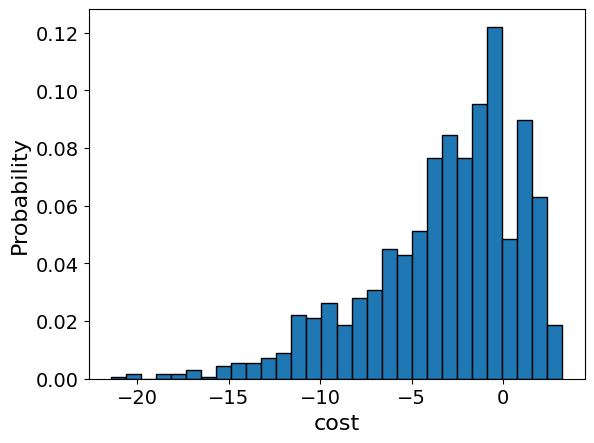

In [20]:
import matplotlib.pyplot as plt
optimization_result["cost"].plot(
    kind="hist", bins=30, edgecolor="black", weights=optimization_result["probability"]
)
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

### Create a Network Graph for the Best Solution Found

**QAOA SOLUTION**
total cost=  -21.442224111866967


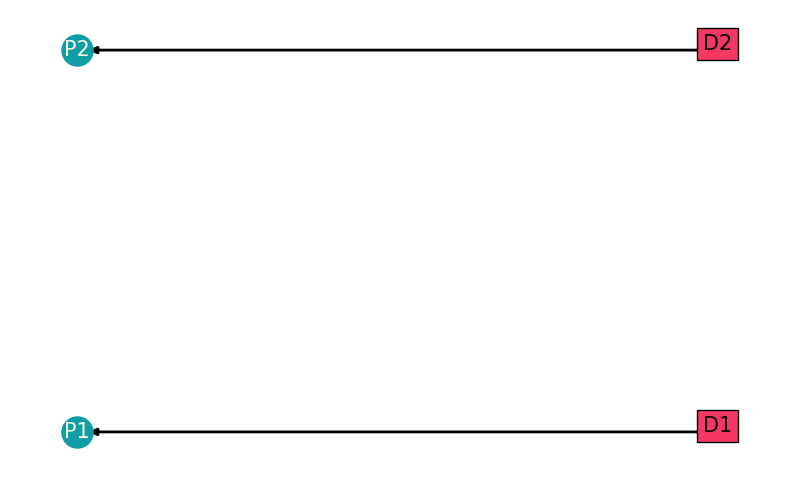

In [21]:
# This function plots the solution in a table and a graph


def plotting_sol(x_sol, cost, is_classic: bool):
    x_sol_to_mat = np.reshape(np.array(x_sol), [N, M])  # vector to matrix
    # opened facilities will be marked in red
    opened_fac_dict = {}
    for fa in range(N):
        if sum(x_sol_to_mat[fa, m] for m in range(M)) > 0:
            opened_fac_dict.update({donors[fa]: "background-color: #F43764"})

    # classical or quantum
    if is_classic == True:
        print("**CLASSICAL SOLUTION**")
        print("total cost= ", cost)
    else:
        print("**QAOA SOLUTION**")
        print("total cost= ", cost)

    # plotting in a table
    df = pd.DataFrame(x_sol_to_mat)
    df.columns = patients
    df.index = donors
    plotable = df.style.apply(lambda x: x.index.map(opened_fac_dict))
    print(plotable)

    # plotting in a graph
    graph_sol = nx.DiGraph()
    graph_sol.add_nodes_from(donors+patients)
    for n, m in product(range(N), range(M)):
        if x_sol_to_mat[n, m] > 0:
            graph_sol.add_edges_from(
                [(donors[m], patients[n])]#, weight=cost_matrix[n, m]
            )

    plt.figure(figsize=(10, 6))
    left = nx.bipartite.sets(graph_sol, top_nodes=patients)[0]
    pos = nx.bipartite_layout(graph_sol, left)

    nx.draw_networkx(
        graph_sol, pos=pos, nodelist=patients, font_size=22, font_color="None"
    )
    nx.draw_networkx_nodes(
        graph_sol, pos, nodelist=patients, node_color="#119DA4", node_size=500
    )
    for fa in donors:
        x, y = pos[fa]
        if fa in opened_fac_dict.keys():
            plt.text(
                x,
                y,
                s=fa,
                bbox=dict(facecolor="#F43764", alpha=1),
                horizontalalignment="center",
                fontsize=15,
            )
        else:
            plt.text(
                x,
                y,
                s=fa,
                bbox=dict(facecolor="#F4F9E9", alpha=1),
                horizontalalignment="center",
                fontsize=15,
            )

    nx.draw_networkx_edges(graph_sol, pos, width=2)
    labels = nx.get_edge_attributes(graph_sol, "weight")
    nx.draw_networkx_edge_labels(graph_sol, pos, edge_labels=labels, font_size=12)
    nx.draw_networkx_labels(
        graph_sol,
        pos,
        labels={co: co for co in patients},
        font_size=15,
        font_color="#F4F9E9",
    )

    plt.axis("off")
    plt.show()


best_solution = optimization_result.loc[optimization_result.cost.idxmin()]

plotting_sol(best_solution.solution, best_solution.cost, is_classic=False)